# CNN Prediction

In [1]:
import os
import re
import copy
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd

import PIL
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

from __future__ import print_function
#import keras
from tensorflow import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

Tensorflow version 2.2.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [3]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [4]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)

In [5]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [6]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

In [7]:
def pred_roc_data(model, img, label_one_hot):
    pred_keras = model.predict(img).ravel() # ravel(): Flatten the array
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_one_hot.ravel(), pred_keras) 
    auc_keras = auc(fpr_keras, tpr_keras)
    return fpr_keras, tpr_keras, auc_keras

In [8]:
def recall_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+keras.backend.epsilon()))

#ref: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

# Processing

In [9]:
img_width, img_height = 224, 224

In [12]:
# ## For rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_del_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_del_image_info.list'

In [13]:
# ## For rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_dup_image_info.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_dup_image_info.list'

In [14]:
# ## For splited rare deletions
# true_file  = '/home/rt2776/cnv_espresso/images_rare/data_backup/true_rare_del_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/data_backup/false_rare_del_splits.list'

In [15]:
# ## For splited rare duplications
# true_file  = '/home/rt2776/cnv_espresso/images_rare/data_backup/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/data_backup/false_rare_dup_splits.list'

### Loading cnv image file paths to list

In [16]:
# true_cnv_df  = pd.read_csv(true_file,  header=0,sep='\t')
# false_cnv_df = pd.read_csv(false_file, header=0,sep='\t')

In [17]:
# true_images_path_list  = true_cnv_df['image_path']
# false_images_path_list = false_cnv_df['image_path']

In [18]:
## For file with image path only:

# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

In [16]:
## For pcgc experimental cnvs
cnv_info_file = '/home/rt2776/cnv_espresso/predict_pcgc/images/pcgc_NimbleGenV2_data_withImagePath.csv'
cnv_info_df   = pd.read_csv(cnv_info_file)

In [20]:
entire_cnv_images_path_list  = cnv_info_df['entire_cnv_path']

In [19]:
pcgc_split_cnv_images_file = '/home/rt2776/cnv_espresso/predict_pcgc/images/split_cnv_list.txt'
pcgc_split_cnv_images_df   = pd.read_csv(pcgc_split_cnv_images_file,header = None)
pcgc_split_cnv_images_list = pcgc_split_cnv_images_df[0]

### Loading images from list to numpy array

In [21]:
# false_img_np = loadImgs(false_images_path_list, img_width, img_height)
# false_img_np.shape

In [22]:
# true_img_np = loadImgs(true_images_path_list, img_width, img_height)
# true_img_np.shape

In [23]:
img_np = loadImgs(entire_cnv_images_path_list, img_width, img_height)
img_np.shape

[2021.02.11-21:48:05] Processing 1 ...
[2021.02.11-21:48:07] Done 51.


(52, 224, 224, 3)

In [21]:
img_np = loadImgs(pcgc_split_cnv_images_list, img_width, img_height)
img_np.shape

[2021.02.17-10:59:10] Processing 1 ...
[2021.02.17-11:00:11] Processing 1001 ...
[2021.02.17-11:00:45] Done 1465.


(1466, 224, 224, 3)

/home/rt2776/cnv_espresso/predict_pcgc/images/split_cnvs/15_1-00296_5_166386727_173073664_NA_DEL_NAtgs_389wins_splits129_39.png


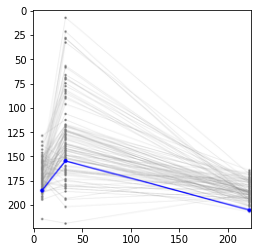

In [23]:
i = 100
#print(cnv_info_df.iloc[i,:])
print(pcgc_split_cnv_images_list[i])
showImg(img_np[i])

### Generage labels

In [25]:
# true_label = [1 for i in range(0,len(true_img_np))]
# false_label = [0 for i in range(0,len(false_img_np))]
# print(true_label[0:5], false_label[0:5])
# print(len(true_label), len(false_label))

### Combine true & false data

In [26]:
# combined_cnv_info_df = true_cnv_df.append(false_cnv_df, ignore_index=True)
# #combined_cnv_info_index = list(range(len(combined_cnv_info_df)))
# combined_img_np = np.vstack((true_img_np, false_img_np))
# combined_label = true_label + false_label

In [27]:
# combined_cnv_info_df.shape, true_cnv_df.shape, false_cnv_df.shape

### Backup or restore

In [28]:
# backup_path = '/home/rt2776/cnv_espresso/images_rare/data_backup/'
# os.makedirs(backup_path, exist_ok=True)

In [29]:
## Backup

# project_name = 'rare_entire_del'
# combined_cnv_info_df.to_csv(backup_path+'rare_del_entire_cnv_info.csv')
# np.save(backup_path+'rare_del_entire_img', combined_img_np)
# np.save(backup_path+'rare_del_entire_label', combined_label)

# project_name = 'rare_entire_dup'
# combined_cnv_info_df.to_csv(backup_path+'rare_entire_dup_info.csv')
# np.save(backup_path+'rare_entire_dup_img', combined_img_np)
# np.save(backup_path+'rare_entire_dup_label', combined_label)

In [30]:
## Restore for entire del or dup

# project_name = 'rare_entire_del'
# project_name = 'rare_entire_dup'

# if project_name == 'rare_entire_del' or project_name == 'rare_entire_dup':
#     combined_img_np = np.load(backup_path + project_name + '_img.npy')
#     combined_label = np.load(backup_path + project_name + '_label.npy')
#     combined_cnv_info_df = pd.read_csv(backup_path+project_name+'_info.csv')

In [31]:
## Restore for split del or dup

# project_name = 'rare_split_del'
# project_name = 'rare_split_dup'

# if project_name == 'rare_split_del' or project_name == 'rare_split_dup':
#     combined_img_np = np.load(backup_path + project_name + '_img.npy')
#     combined_label  = np.load(backup_path + project_name + '_label.npy')
#     try:
#         del combined_cnv_info_df
#     except:
#         pass

In [32]:
# print("Project: '%s' dataset loaded."%project_name)
# print("  -- Shape of image array: ", combined_img_np.shape)
# print("  -- Shape of label      : ", combined_label.shape)
# try:
#     print("  -- Shape of CNV info   : ", combined_cnv_info_df.shape)
# except:
#     print("There is no CNV info data for split del or dup.")

## Normalization

In [24]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = img_np.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [25]:
# Change to float datatype
img_np = img_np.astype('float32')

# Scale the data to lie between 0 to 1
img_np /= 255

In [26]:
# Find the unique numbers from the train labels
nClasses = 3
print('Total number classes: ', nClasses)

Total number classes:  3


In [36]:
#np.where(test_label==0)

/home/rt2776/cnv_espresso/predict_pcgc/images/split_cnvs/22_1-02625_8_8102183_12190106_NA_DUP_NAtgs_171wins_splits57_15.png


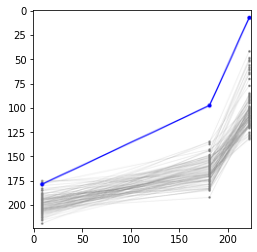

In [31]:
item = random.randint(0,len(img_np))
# print(cnv_info_df.iloc[item,:])
print(pcgc_split_cnv_images_list[item])
showImg(img_np[item])

## Precision

In [32]:
## Load pre-calculated model
custom_objects = {"f1_m":f1_m, "precision_m":precision_m, "recall_m":recall_m}

model_name = 'MobileNet_v1'
# model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_entire_cnv_MobileNet_v1_fold3.h5'
model_path = '/home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_cnv_3classes_MobileNet_v1_3classes_fold4.h5'
print("Loading %s ... from %s"%(model_name, model_path))
MobileNet_model = keras.models.load_model(model_path, custom_objects=custom_objects)

Loading MobileNet_v1 ... from /home/rt2776/cnv_espresso/images_rare_3classes/data_backup/model_h5/rare_split_cnv_3classes_MobileNet_v1_3classes_fold4.h5


In [33]:
img_pred = MobileNet_model.predict(img_np)

In [34]:
img_pred

array([[2.6206899e-09, 3.3603464e-03, 9.9663961e-01],
       [2.6206899e-09, 3.3603464e-03, 9.9663961e-01],
       [2.6206899e-09, 3.3603464e-03, 9.9663961e-01],
       ...,
       [2.6206899e-09, 3.3603464e-03, 9.9663961e-01],
       [2.6206899e-09, 3.3603464e-03, 9.9663961e-01],
       [4.8847590e-03, 4.2590988e-01, 5.6920540e-01]], dtype=float32)

/home/rt2776/cnv_espresso/predict_pcgc/images/split_cnvs/44_1-01536_19_47792293_47905132_NA_DEL_NAtgs_22wins_splits7_7.png
[0.5642458  0.43480393 0.0009502 ]


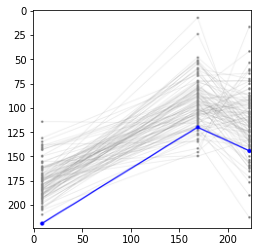

In [56]:
# for pcgc split cnvs
item =  883
# print(cnv_info_df.iloc[item,:])
print(pcgc_split_cnv_images_list[item])
print(img_pred[item,:])
showImg(img_np[item])


In [35]:
[0.62885785 0.3701436  0.00099856]
[4.2901874e-01 5.7092142e-01 5.9812079e-05]
[6.9849491e-01 3.0136994e-01 1.3517542e-04]
[2.5357664e-01 7.4642164e-01 1.6528876e-06]
[0.56531954 0.43357664 0.00110377]
[0.6552619  0.3387185  0.00601963]
[0.5642458  0.43480393 0.0009502 ]

(1466, 3)

In [67]:
pred_output_df = copy.deepcopy(cnv_info_df)
pred_output_df.shape

(52, 17)

In [81]:
print("4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup")
print("3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup")

pred_output_df.insert(pred_output_df.shape[1], 'Prob_DEL', "-")
pred_output_df.insert(pred_output_df.shape[1], 'Prob_DIP', "-")
pred_output_df.insert(pred_output_df.shape[1], 'Prob_DUP', "-")
pred_output_df.insert(pred_output_df.shape[1], 'Prediction', "-")
pred_output_df.insert(pred_output_df.shape[1], 'Status', "-")

4 classes label: 0-True del; 1-False del; 2-False dup; 3-True dup
3 classes label: 0-True del; 1-False del; 1-False dup; 2-True dup


In [80]:
pred_output_df['CNV_TYPE'] = pred_output_df['CNV_TYPE'].replace(1,"DEL")
pred_output_df['CNV_TYPE'] = pred_output_df['CNV_TYPE'].replace(3,"DUP")

In [82]:
num, correct_count = 0, 0
for i in range(len(img_pred)):
    num += 1
    pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prob_DEL')] = img_pred[i][0]
    pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prob_DIP')] = img_pred[i][1]
    pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prob_DUP')] = img_pred[i][2]

    if(np.argmax(img_pred[i]) == 0):
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prediction')] = "DEL"
    elif(np.argmax(img_pred[i]) == 1):
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prediction')] = "DIP"
    elif(np.argmax(img_pred[i]) == 2):
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prediction')] = "DUP"
    else:
        pdb.set_trace()
        
    if pred_output_df.iloc[i,pred_output_df.columns.get_loc('Prediction')] == pred_output_df.iloc[i,pred_output_df.columns.get_loc('CNV_TYPE')]:
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Status')] = "Correct"
    else:
        pred_output_df.iloc[i,pred_output_df.columns.get_loc('Status')] = "Wrong"
    

In [88]:
accuracy_rate = len(pred_output_df[pred_output_df['Status'] == "Correct"])/len(pred_output_df)
print("Accuracy rate:",accuracy_rate)

Accuracy rate: 0.7115384615384616


In [89]:
## output to file
output_path = '/home/rt2776/cnv_espresso/predict_pcgc/'
pred_output_df.to_csv(output_path+'pcgc_NimbleGenV2_data_prediction.csv',index=False)


In [ ]:
# test_output_df[test_output_df['SAMPLE']=='SP0009081'] 

In [ ]:
# test_output_df[test_output_df['Pred_status']=='Wrong']

In [ ]:
# test_output_df.index=range(len(test_output_df))

In [ ]:
# #i=random.randrange(len(test_img))
# i=random.choice(test_output_df[test_output_df['Pred_status']=='Wrong'].index)
# showImg(test_img[i]), 
# print(test_label[i], test_pred[i],  test_output_df.iloc[i,:])

### Predict specific images

In [ ]:
# # ## For splited rare duplications
# true_file  = '/home/rt2776/cnv_espresso/images_rare/data_backup/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/data_backup/false_rare_dup_splits.list'

In [ ]:
# true_cnv_df  = pd.read_csv(true_file,  header=None,sep='\t')
# false_cnv_df = pd.read_csv(false_file, header=None,sep='\t')

In [ ]:
# true_cnv_df.columns = ['image_path']
# false_cnv_df.columns = ['image_path']

In [ ]:
# #specific_images_path_df = false_cnv_df[false_cnv_df['image_path'].str.contains('SP0009081')]
# specific_images_path_df = true_cnv_df[true_cnv_df['image_path'].str.contains('SP0077668_2_172795024')]
# specific_images_path_list = specific_images_path_df['image_path']
# specific_images_path_list

In [ ]:
# img_width, img_height = 224, 224
# specific_img_np = loadImgs(specific_images_path_list, img_width, img_height)

In [ ]:
# specific_img_np.shape

In [ ]:
# specific_img_np = specific_img_np.astype('float32')
# specific_img_np /= 255

In [ ]:
# showImg(specific_img_np[2])

In [ ]:
# MobileNet_model.predict(specific_img_np)

In [ ]:
# np.argmax(MobileNet_model.predict(specific_img_np)[2])

### TODO:
- Check the performance on different size categories on test data firstly and by k-fold cross validation secondly. 

## Reference:
- Load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy demo: https://zhuanlan.zhihu.com/p/51889181
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a